# 📘 Revenue Attribution Analysis for Megaline Prepaid Plans

## Project Overview

As a data analyst at **Megaline**, I am conducting a comprehensive **revenue attribution analysis** to evaluate the financial performance of our two prepaid mobile plans—**Surf** and **Ultimate**. This analysis supports the Commercial department’s strategic goal of reallocating marketing resources toward the more profitable plan, using evidence-based insights derived from 2018 usage data of a representative sample of 500 customers.

The analysis includes usage metrics for **voice calls**, **text messages**, and **internet data**, tied to individual user profiles and plan selections. By applying the correct billing rules and calculating monthly revenue per user, we aim to identify which plan delivers higher average returns.

---

📦 Description of the Plans

> **Note:**  
> - Call durations are **rounded up to the nearest minute** per call.  
> - Data usage is aggregated monthly, then **rounded up to the nearest gigabyte** (1 GB = 1024 MB).

 Surf Plan
- **Monthly charge:** $20  
- **Included:** 500 minutes, 50 text messages, and 15 GB of data  
- **Overage rates:**  
  - $0.03 per additional minute  
  - $0.03 per additional text  
  - $10 per additional GB of data  

 Ultimate Plan
- **Monthly charge:** $70  
- **Included:** 3000 minutes, 1000 text messages, and 30 GB of data  
- **Overage rates:**  
  - $0.01 per  additional  minute  
  - $0.01 per  additional  text  
  - $7 per additional GB of data  

---

### Analytical Objectives

1. **Data Preprocessing & Validation**
   - Load and standardize data from multiple sources: calls, messages, internet sessions, plan details, and customer profiles
   - Identify and correct data type mismatches, handle nulls, and prepare the data for monthly aggregation

2. **Usage Aggregation**
   - Derive monthly totals for:
     - Voice minutes (rounded per call)
     - Number of SMS messages
     - Monthly data volume (rounded to GB)

3. **Revenue Calculation**
   - For each user, calculate monthly revenue by:
     - Subtracting included limits
     - Applying overage charges where applicable
     - Adding base subscription fees

4. **Descriptive Analysis**
   - Assess usage distributions and customer behavior for each plan
   - Compute statistical measures (mean, variance, standard deviation)
   - Visualize with histograms for comparison

5. **Hypothesis Testing**
   - **Hypothesis 1:** Average monthly revenue differs between Surf and Ultimate plans  
   - **Hypothesis 2:** Average revenue for users in the NY-NJ area differs from those in other regions  
   - Apply two-sample t-tests with appropriate alpha levels and document all statistical assumptions

6. **Conclusion & Recommendations**
   - Synthesize key findings
   - Identify statistically significant revenue differences
   - Recommend marketing adjustments and strategic investments based on user profitability

---

This analysis will equip internal stakeholders with clear, data-driven insights to **optimize marketing strategy**, enhance **customer segmentation**, and ensure **resource allocation aligns with revenue potential**.


## Initialization

Load python libraries as needed for completion of project.

In [56]:
import pandas as pd 
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
from scipy.stats import norm
import seaborn as sns

## Load data

Load datasets with descriptive and memorable names.

In [57]:
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')


## Prepare the data

### Plans

In [58]:
# Print the general/summary information about the plans' DataFrame
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [59]:
# Print a sample of data for plans
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Quick Note on the Dataset

This dataset looks super clean and pretty short. According to the company’s guidelines, the data is accurate—which is great!

That said, we should convert any USD-related columns to `float` data types. This will help keep things consistent and make future calculations easier if needed.



### Fix data

In [60]:
plans['usd_monthly_pay']= plans['usd_monthly_pay'].astype('float')
plans['usd_per_gb']= plans['usd_per_gb'].astype('float')
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      float64
 4   usd_per_gb             2 non-null      float64
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(4), int64(3), object(1)
memory usage: 256.0+ bytes


### Enrich data

In [61]:
plans['gb_included'] = np.ceil(plans['mb_per_month_included']/1024)
plans.drop('mb_per_month_included', axis=1, inplace=True)

## Users

In [62]:
# Print the general/summary information about the users' DataFrame
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [63]:
# Print a sample of data for users
users

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


 Quick Data Check & Cleanup Ideas

- **`user_id` column**  
  It's currently an `int64`, but since we’re not doing math on IDs, we should probably convert it to an `object` type instead.

- **Date columns**  
  Both `reg_date` and `churn_date` are stored as `object` types. These should be converted to proper `datetime` format so we can easily filter, sort, or calculate time-based metrics.

- **City naming issue**  
  Noticed a mismatch in the `city` column—some entries use "MSA" and others "USA." We'll want to standardize this for consistency.

- **Duplicates**  
  Worth checking the dataset for duplicate rows just to make sure everything’s clean.

- **Nulls in `churn_date`**  
  Lots of nulls here, but according to the data dictionary, that’s expected—it likely means the user hasn’t churned yet.

- **City breakdown**  
  Thinking about splitting the `city` column into separate fields for city, region, and country. Could be helpful for analysis. Might also look into how this info is stored in the database to clean it up at the source.



### Fix Data

In [64]:
users['reg_date']= pd.to_datetime(users['reg_date'], infer_datetime_format=True)
users['churn_date']= pd.to_datetime(users['churn_date'], infer_datetime_format=True)
users['user_id']= users['user_id'].astype('object')
users = users.rename(columns={'plan': 'plan_name'})
users['city'] = users['city'].str.replace('MSA', 'USA')

In [65]:
users.duplicated().sum()

0

### Enrich Data

Thinking about splitting the `city` column into separate fields for city, region, and country. Could be helpful for analysis. Might also look into how this info is stored in the database to clean it up at the source.

In [66]:
cities = users['city'].unique()
cities   

array(['Atlanta-Sandy Springs-Roswell, GA USA',
       'Seattle-Tacoma-Bellevue, WA USA',
       'Las Vegas-Henderson-Paradise, NV USA', 'Tulsa, OK USA',
       'Dallas-Fort Worth-Arlington, TX USA',
       'San Francisco-Oakland-Berkeley, CA USA',
       'Grand Rapids-Kentwood, MI USA',
       'Orlando-Kissimmee-Sanford, FL USA',
       'San Jose-Sunnyvale-Santa Clara, CA USA',
       'Cleveland-Elyria, OH USA',
       'Chicago-Naperville-Elgin, IL-IN-WI USA', 'Knoxville, TN USA',
       'New York-Newark-Jersey City, NY-NJ-PA USA', 'Pittsburgh, PA USA',
       'Fresno, CA USA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV USA',
       'Indianapolis-Carmel-Anderson, IN USA', 'Jacksonville, FL USA',
       'Los Angeles-Long Beach-Anaheim, CA USA',
       'Omaha-Council Bluffs, NE-IA USA',
       'Houston-The Woodlands-Sugar Land, TX USA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD USA',
       'Tampa-St. Petersburg-Clearwater, FL USA',
       'Birmingham-Hoover, AL USA'

In [67]:
users[['city', 'region']] = users['city'].str.split(', ', expand=True)
users[['region', 'country']] = users['region'].str.split(' ', expand=True)
users['region'] = users['region'].str.replace('PA-NJ-DE-MD', 'PA-NJ-DE')
users['region'] = users['region'].str.replace('NY-NJ-PA', 'NY-NJ')
users['region'] = users['region'].str.replace('DC-VA-MD-WV', 'DC-VA-MD')
users = users[['user_id','first_name','last_name','age', 'city','region','country','reg_date', 'plan_name','churn_date']]
users['month_joined'] = users['reg_date'].dt.month_name()
users.head(5)

,user_id,first_name,last_name,age,city,region,country,reg_date,plan_name,churn_date,month_joined
0,1000,Anamaria,Bauer,45,Atlanta-Sandy Springs-Roswell,GA,USA,2018-12-24,ultimate,NaT,December
1,1001,Mickey,Wilkerson,28,Seattle-Tacoma-Bellevue,WA,USA,2018-08-13,surf,NaT,August
2,1002,Carlee,Hoffman,36,Las Vegas-Henderson-Paradise,NV,USA,2018-10-21,surf,NaT,October
3,1003,Reynaldo,Jenkins,52,Tulsa,OK,USA,2018-01-28,surf,NaT,January
4,1004,Leonila,Thompson,40,Seattle-Tacoma-Bellevue,WA,USA,2018-05-23,surf,NaT,May


Wrapping Up User Dataset Edits

I think we’ve done enough cleaning on the users dataset for now.

One thing to keep in mind: I'd like to revisit how location data is stored in the database. Improving this could really help create a smoother, more targeted marketing strategy.

Just leaving this as a reminder to follow up with the DB admin and architect later—it could make regional sales insights more accurate.


## Calls

In [68]:
# Print the general/summary information about the calls' DataFrame
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [69]:
# Print a sample of data for calls

calls

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37


Notes on Call Data Cleanup

- `user_id` is showing up as an `int` again—it should be an `object` since we're not doing any math on it.

- Call durations need to be rounded up, since that aligns with the standard billing method used.

- `call_date` should be converted to `datetime` format so we can work with it more easily.

- Just for curiosity, I’d like to add the month for each call—might be interesting to see if there are patterns in call activity across different months later.

- Also, renaming the `id` column to `call_id` for clarity:
  


### Fix data

In [70]:
calls['call_date']= pd.to_datetime(calls['call_date'], infer_datetime_format=True)
calls['user_id']= calls['user_id'].astype('object')
calls['duration'] = np.ceil(calls['duration'])
calls = calls.rename(columns={'id': 'call_id'})
calls.tail()

,call_id,user_id,call_date,duration
137730,1499_199,1499,2018-11-21,9.0
137731,1499_200,1499,2018-10-20,11.0
137732,1499_201,1499,2018-09-21,9.0
137733,1499_202,1499,2018-10-10,1.0
137734,1499_203,1499,2018-12-29,14.0


### Enrich data

In [71]:
calls['month'] = calls['call_date'].dt.month_name()
calls

,call_id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,December
1,1000_145,1000,2018-12-27,14.0,December
2,1000_247,1000,2018-12-27,15.0,December
3,1000_309,1000,2018-12-28,6.0,December
4,1000_380,1000,2018-12-30,5.0,December
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,9.0,November
137731,1499_200,1499,2018-10-20,11.0,October
137732,1499_201,1499,2018-09-21,9.0,September
137733,1499_202,1499,2018-10-10,1.0,October


✅ Summary of Actions Performed on Call Data

- Converted `user_id` to `object` type to avoid unintentional numerical operations.
- Rounded up call durations to match the standard billing method.
- Converted `call_date` from object to proper `datetime` format.
- Added new columns for:
  - **Month** (`month`)
- Renamed the `id` column to `call_id` for better clarity:
  ```python
  calls = calls.rename(columns={'id': 'call_id'})


## Messages

In [72]:
# Print the general/summary information about the messages' DataFrame
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [73]:
# Print a sample of data for messages

messages

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


Notes on Messages Data Cleanup

- Need to convert `user_id` to `object` type—same as in the other datasets.
- `message_date` should be converted to `datetime` format for better handling.
- I’d also like to add a new column for **month** to explore consumer behavior over time—could be interesting to see if messaging patterns change by month.


### Fix data

In [74]:
messages['message_date']= pd.to_datetime(messages['message_date'], infer_datetime_format=True)
messages['user_id']= messages['user_id'].astype('object')
messages = messages.rename(columns={'id': 'messages_id'})

### Enrich data

In [75]:
messages['month'] = messages['message_date'].dt.month_name()
messages.tail()

,messages_id,user_id,message_date,month
76046,1497_526,1497,2018-12-24,December
76047,1497_536,1497,2018-12-24,December
76048,1497_547,1497,2018-12-31,December
76049,1497_558,1497,2018-12-24,December
76050,1497_613,1497,2018-12-23,December


## Internet

In [76]:
# Print the general/summary information about the internet DataFrame
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [77]:
# Print a sample of data for the internet traffic
internet

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00


Notes on Sessions Data Cleanup

- `user_id` should be converted to `object` type for consistency.
- `session_date` needs to be converted to `datetime` format.
- I’d also like to add new columns for **month** and **day of the week** to explore user behavior and session trends over time.


### Fix data

In [78]:
internet['session_date']= pd.to_datetime(internet['session_date'], infer_datetime_format=True)
internet['user_id']= internet['user_id'].astype('object')
internet = internet.rename(columns={'id': 'internet_id'})


### Enrich data

In [79]:
internet['month'] = internet['session_date'].dt.month_name()
internet['gb_used'] = internet['mb_used']/1024
internet.drop('mb_used', axis=1, inplace=True)
internet.tail()

,internet_id,user_id,session_date,month,gb_used
104820,1499_215,1499,2018-10-20,October,0.212949
104821,1499_216,1499,2018-12-30,December,0.297578
104822,1499_217,1499,2018-09-22,September,0.285889
104823,1499_218,1499,2018-12-07,December,0.000000
104824,1499_219,1499,2018-12-24,December,0.740537


## Study plan conditions

In [80]:
# Print out the plan conditions and make sure they are clear for you
plans


,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_included
0,50,500,20.0,10.0,0.03,0.03,surf,15.0
1,1000,3000,70.0,7.0,0.01,0.01,ultimate,30.0


📦 **Description of the Plans**

> **Note:**  
> - Call durations are **rounded up to the nearest minute** per call.  
> - Data usage is aggregated monthly, then **rounded up to the nearest gigabyte** (1 GB = 1024 MB).

---

Surf Plan
- **Monthly charge:** $20  
- **Included:**  
  - 500 minutes  
  - 50 text messages  
  - 15 GB of data  
- **Overage rates:**  
  - $0.03 per additional minute  
  - $0.03 per additional text message  
  - $10 per additional GB of data  

---

Ultimate Plan
- **Monthly charge:** $70  
- **Included:**  
  - 3000 minutes  
  - 1000 text messages  
  - 30 GB of data  
- **Overage rates:**  
  - $0.01 per additional minute  
  - $0.01 per additional text message  
  - $7 per additional GB of data


## Aggregate data per user


In [81]:
# Calculate the number of calls made by each user per month. Save the result.
calls_by_user = calls.groupby(['user_id', 'month'])['call_id'].count()
calls_by_user = calls_by_user.reset_index()
calls_by_user = calls_by_user.rename( columns={ 'call_id': 'amount_of_calls'})
calls_by_user = calls_by_user.fillna(0)
calls_by_user.head()

,user_id,month,amount_of_calls
0,1000,December,16
1,1001,August,27
2,1001,December,56
3,1001,November,64
4,1001,October,65


In [82]:
# Calculate the amount of minutes spent by each user per month. Save the result.
min_by_user = calls.groupby(['user_id', 'month'])['duration'].sum()
min_by_user = min_by_user.reset_index()
min_by_user = min_by_user.rename( columns={ 'duration': 'calls_duration'})
min_by_user = min_by_user.fillna(0)
min_by_user.head()

,user_id,month,calls_duration
0,1000,December,124.0
1,1001,August,182.0
2,1001,December,412.0
3,1001,November,426.0
4,1001,October,393.0


In [83]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_by_user = messages.groupby(['user_id', 'month'])['messages_id'].count()
messages_by_user = messages_by_user.reset_index()
messages_by_user = messages_by_user.rename( columns={ 'messages_id': 'sent_messages'})
messages_by_user = messages_by_user.fillna(0)
messages_by_user.head()

,user_id,month,sent_messages
0,1000,December,11
1,1001,August,30
2,1001,December,44
3,1001,November,36
4,1001,October,53


In [84]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_by_user = internet.groupby(['user_id', 'month'])['gb_used'].sum()
internet_by_user = internet_by_user.reset_index()
internet_by_user = internet_by_user.fillna(0)
internet_by_user.head()

,user_id,month,gb_used
0,1000,December,1.856904
1,1001,August,6.756982
2,1001,December,18.915215
3,1001,November,18.070605
4,1001,October,21.807119


[Put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.]

In [85]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
monthly_usage = pd.merge(internet_by_user, min_by_user,  
                    on=['user_id', 'month'], how ='left')
monthly_usage = pd.merge(monthly_usage, calls_by_user,  
                    on=['user_id', 'month'], how ='left')
monthly_usage = pd.merge(monthly_usage, messages_by_user,  
                    on=['user_id', 'month'], how ='left')
monthly_usage.head()

,user_id,month,gb_used,calls_duration,amount_of_calls,sent_messages
0,1000,December,1.856904,124.0,16.0,11.0
1,1001,August,6.756982,182.0,27.0,30.0
2,1001,December,18.915215,412.0,56.0,44.0
3,1001,November,18.070605,426.0,64.0,36.0
4,1001,October,21.807119,393.0,65.0,53.0


In [86]:
# Add the plan information
plan = users[['user_id', 'plan_name','region']]
monthly_usage = pd.merge(monthly_usage, plan,  
                    on='user_id', how ='left')
#monthly_usage = monthly_usage.fillna(0)

monthly_usage.head()  


,user_id,month,gb_used,calls_duration,amount_of_calls,sent_messages,plan_name,region
0,1000,December,1.856904,124.0,16.0,11.0,ultimate,GA
1,1001,August,6.756982,182.0,27.0,30.0,surf,WA
2,1001,December,18.915215,412.0,56.0,44.0,surf,WA
3,1001,November,18.070605,426.0,64.0,36.0,surf,WA
4,1001,October,21.807119,393.0,65.0,53.0,surf,WA


In [87]:
revenue = pd.merge(monthly_usage, plans, on='plan_name', how='left')

# Convert over_mb from MB to GB (rounding up for billing accuracy)
revenue['gb_used'] = np.ceil(revenue['gb_used'] )
# Calculate overages for each column
revenue['over_gb'] = revenue['gb_used'] - revenue['gb_included']
revenue['over_mess'] = revenue['sent_messages'] - revenue['messages_included']
revenue['over_call'] = revenue['calls_duration'] - revenue['minutes_included']

# Ensure overage values are non-negative
revenue[['over_gb', 'over_mess', 'over_call']] = revenue[['over_gb', 'over_mess', 'over_call']].clip(lower=0)



# Vectorized revenue calculation
revenue['revenue'] = (
    revenue['usd_monthly_pay'] + 
    revenue['over_gb'] * revenue['usd_per_gb'] + 
    revenue['over_mess'] * revenue['usd_per_message'] + 
    revenue['over_call'] * revenue['usd_per_minute']
)

# Calculate overage revenue
revenue['overage_rev'] = revenue['revenue'] - revenue['usd_monthly_pay']

# Select final columns for output
user_revenue = revenue[[
    'user_id', 'month', 'gb_used', 'calls_duration', 
    'sent_messages', 'amount_of_calls', 'plan_name', 
    'revenue', 'overage_rev', 'region'
]]
user_revenue

,user_id,month,gb_used,calls_duration,sent_messages,amount_of_calls,plan_name,revenue,overage_rev,region
0,1000,December,2.0,124.0,11.0,16.0,ultimate,70.00,0.00,GA
1,1001,August,7.0,182.0,30.0,27.0,surf,20.00,0.00,WA
2,1001,December,19.0,412.0,44.0,56.0,surf,60.00,40.00,WA
3,1001,November,19.0,426.0,36.0,64.0,surf,60.00,40.00,WA
4,1001,October,22.0,393.0,53.0,65.0,surf,90.09,70.09,WA
...,...,...,...,...,...,...,...,...,...,...
2272,1498,September,23.0,363.0,NaN,45.0,surf,NaN,NaN,NY-NJ
2273,1499,December,22.0,496.0,NaN,65.0,surf,NaN,NaN,FL
2274,1499,November,17.0,308.0,NaN,45.0,surf,NaN,NaN,FL
2275,1499,October,20.0,385.0,NaN,53.0,surf,NaN,NaN,FL


## Study user behaviour



To explore how users interact with their mobile plans over time, we will analyze monthly trends across four key areas: **call duration**, **messages sent**, **internet data usage**, and **revenue generated**.

For each dataset, we will calculate the total usage or revenue per plan for each month of 2018. These results will then be visualized using histograms to highlight any seasonal patterns, shifts in behavior, or plan-specific differences.

This approach will provide a clear view of user activity across the year, laying the foundation for deeper analysis into how engagement and usage may vary over time and across different service plans.


### Calls

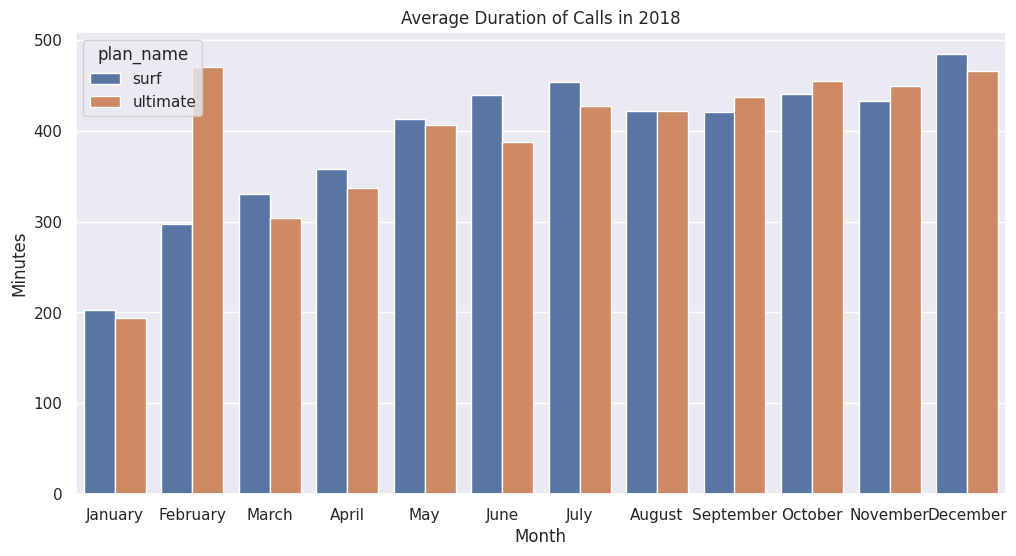

In [88]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
avg_duration = monthly_usage.groupby(['plan_name', 'month'])['calls_duration'].mean().reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

avg_duration['month'] = pd.Categorical(avg_duration['month'], categories=months_order, ordered=True)
avg_duration = avg_duration.sort_values('month')
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data = avg_duration, x='month', y='calls_duration', hue='plan_name', ax =ax)

plt.title("Average Duration of Calls in 2018")
plt.xlabel('Month')
plt.ylabel('Minutes')

plt.show()




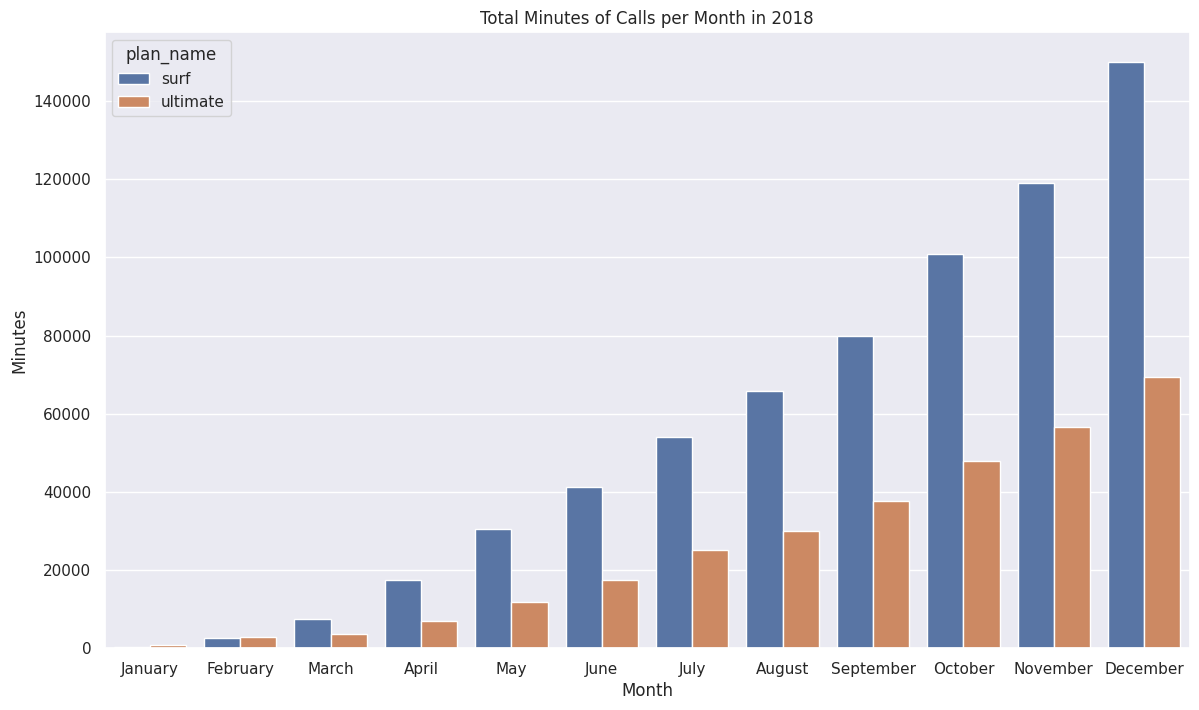

In [34]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
minutes = monthly_usage.groupby(['plan_name', 'month'])['calls_duration'].sum().reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

minutes['month'] = pd.Categorical(minutes['month'], categories=months_order, ordered=True)
minutes = minutes.sort_values('month')
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(data = minutes, x='month', y='calls_duration', hue='plan_name', ax =ax)

plt.title("Total Minutes of Calls per Month in 2018")
plt.xlabel('Month')
plt.ylabel('Minutes')
plt.show()


In [35]:
# Calculate the mean and the variance of the monthly call duration
mean_var = monthly_usage.groupby('month').agg({'calls_duration': ['mean', 'var']}).reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

mean_var['month'] = pd.Categorical(mean_var['month'], categories=months_order, ordered=True)
mean_var = mean_var.sort_values('month')

mean_var

month calls_duration              
                        mean           var
4     January     196.666667  13135.866667
3    February     343.437500  61567.329167
7       March     321.171429  43378.499160
0       April     351.528571  44930.368737
8         May     402.942857  55225.996703
6        June     413.323944  44434.702827
5        July     442.016760  64850.735673
1      August     416.178261  53214.749744
11  September     421.200717  49905.916402
10    October     438.504425  52489.937111
9    November     430.566176  54140.703227
2    December     468.829060  63283.131316

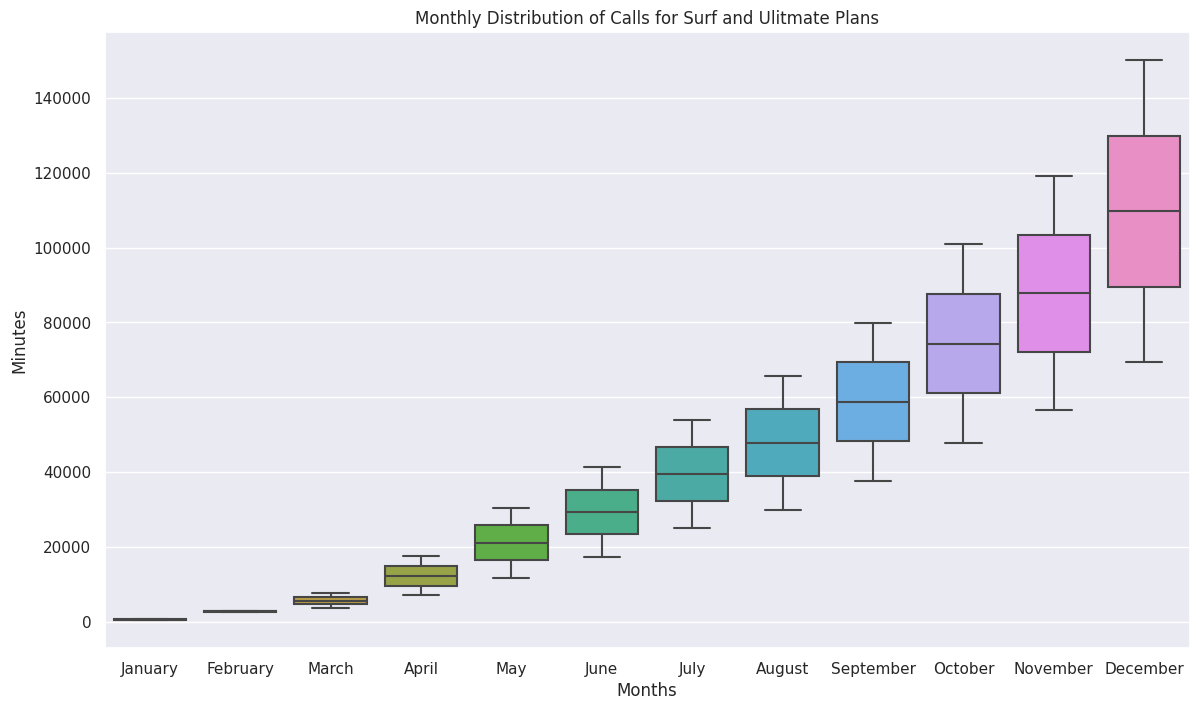

In [36]:
# Plot a boxplot to visualize the distribution of the monthly call duration
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data =minutes, y='calls_duration', x='month', ax = ax )

plt.title("Monthly Distribution of Calls for Surf and Ulitmate Plans")
plt.xlabel('Months')
plt.ylabel('Minutes')

plt.show()


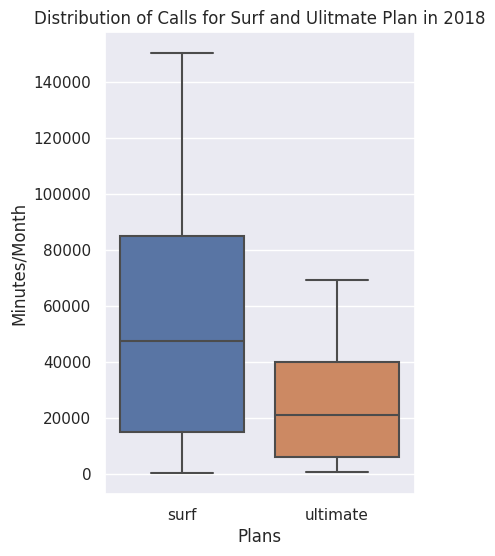

In [37]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.boxplot(data =minutes, y='calls_duration', x='plan_name', ax = ax )

plt.title("Distribution of Calls for Surf and Ulitmate Plan in 2018")
plt.xlabel('Plans')
plt.ylabel('Minutes/Month')

plt.show()

Call Usage Analysis Summary

Based on the visualizations, the **average call duration per plan per month** initially suggested that users were consistently using a similar number of minutes each month. However, a deeper dive into the data revealed a **notable shift starting in July**, with total call minutes **increasing significantly through December**, peaking during the holiday season. 

Interestingly, **January saw the lowest usage**, which raises the question: *Are users experiencing post-holiday fatigue?* If so, this insight could inform future **marketing strategies** aimed at boosting engagement during this low-activity period.

The **Surf plan** consistently showed the **highest call minute usage**. This raises several key questions:
- Are Surf users making more frequent calls?
- Are their calls lasting longer?
- Has there been a spike in new Surf subscribers during these high-usage months?

While **average call duration appears steady across most months**, this metric might be **masking underlying variances** in user behavior. These nuances warrant **further exploration**.

Additionally, although **Ultimate plan customers** have access to more minutes, **Surf users consistently consume more call minutes on a monthly basis**. This usage pattern may present an opportunity to investigate:
- **Revenue generated from call usage**
- Whether increased usage correlates with **higher customer value**

These insights can guide future decisions around **plan structure, marketing focus**, and **user engagement strategies**.


### Messages

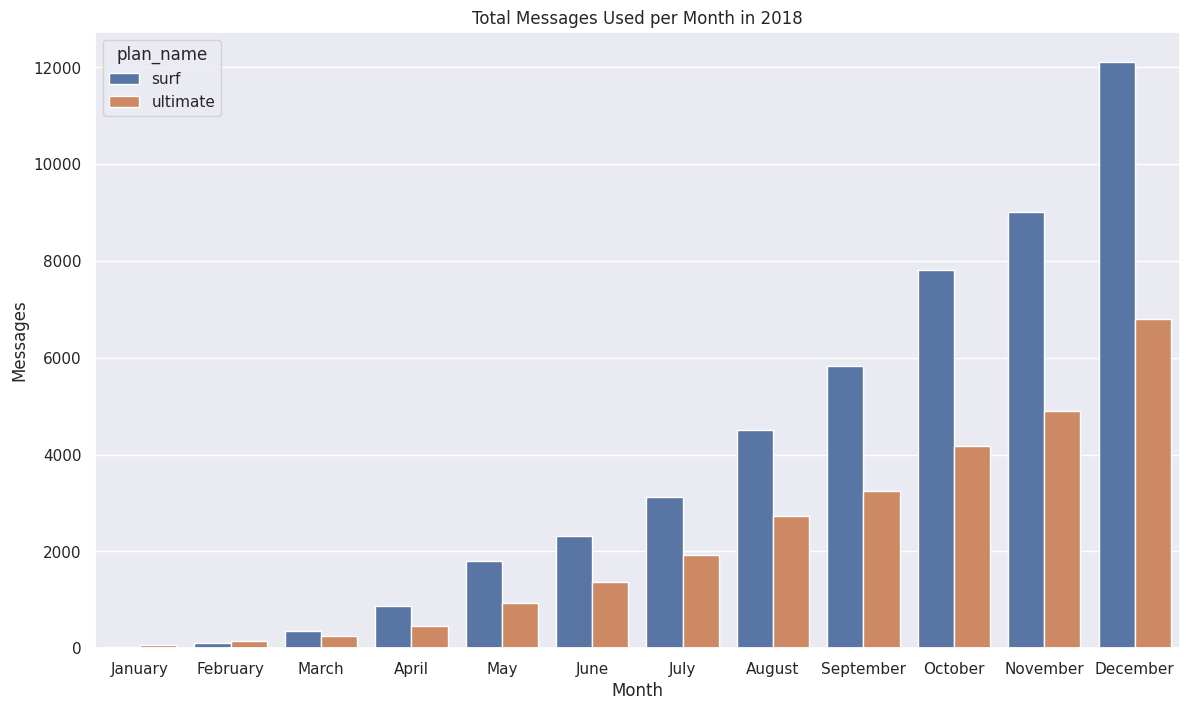

In [38]:
#Compare the number of messages users of each plan tend to send each month
messages_trends = monthly_usage.groupby(['plan_name', 'month'])['sent_messages'].sum().reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

messages_trends['month'] = pd.Categorical(messages_trends['month'], categories=months_order, ordered=True)
messages_trends = messages_trends.sort_values('month')
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(data = messages_trends, x='month', y='sent_messages', hue='plan_name', ax =ax)

plt.title("Total Messages Used per Month in 2018")
plt.xlabel('Month')
plt.ylabel('Messages')
plt.show()

In [39]:
# Calculate the mean and the variance of the monthly messages

mess_mean_var = monthly_usage.groupby('month').agg({'sent_messages': ['mean', 'var']}).reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

mess_mean_var['month'] = pd.Categorical(mess_mean_var['month'], categories=months_order, ordered=True)
mess_mean_var = mess_mean_var.sort_values('month')

mess_mean_var

month sent_messages             
                       mean          var
4     January     13.833333   238.966667
3    February     16.187500   421.229167
7       March     16.971429   441.734454
0       April     18.957143   516.157557
8         May     25.990476   975.682601
6        June     26.042254   821.487564
5        July     28.273743   864.570711
1      August     31.500000  1050.748908
11  September     32.605735   995.131766
10    October     35.362832  1232.882756
9    November     34.095588  1088.941700
2    December     40.423077  1469.388074

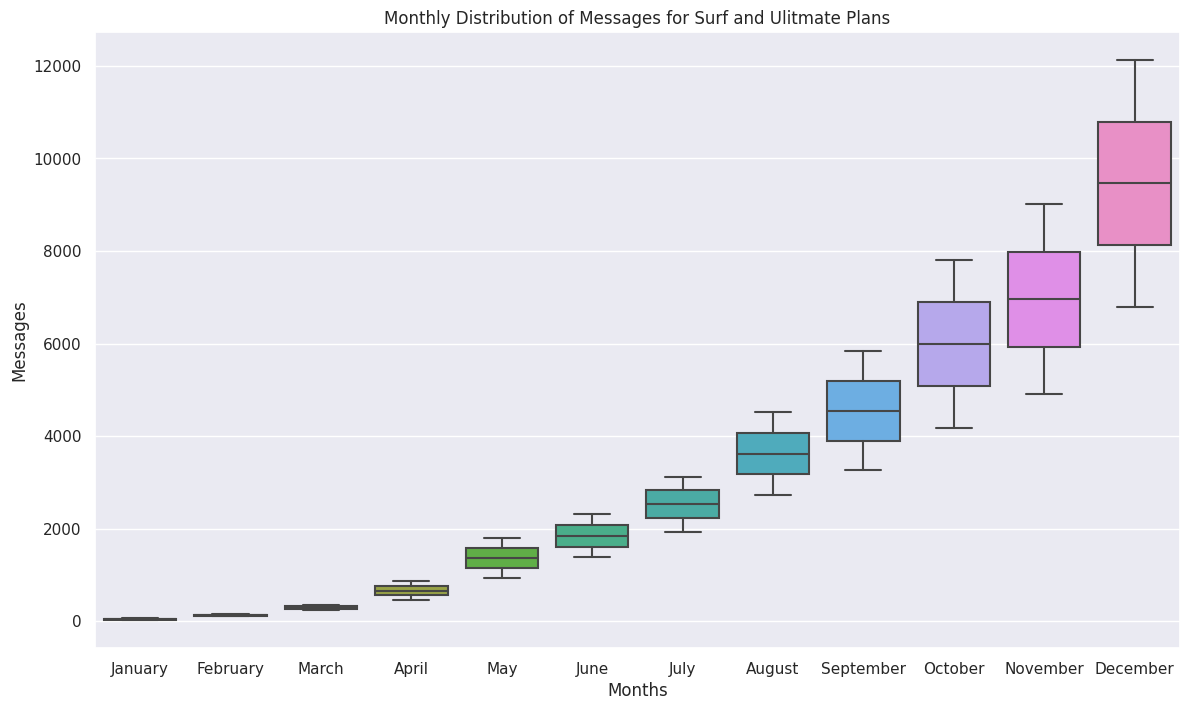

In [40]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data =messages_trends, y='sent_messages', x='month', ax = ax )

plt.title("Monthly Distribution of Messages for Surf and Ulitmate Plans")
plt.xlabel('Months')
plt.ylabel('Messages')

plt.show()

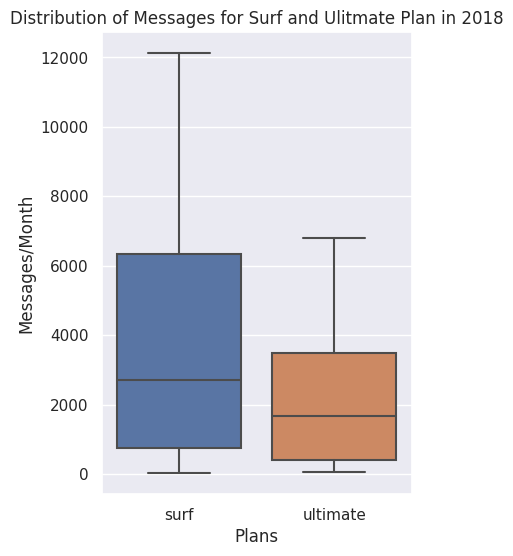

In [41]:
# Plot a boxplot to visualize the distribution of the monthly messages
fig, ax = plt.subplots(figsize=(4, 6))
sns.boxplot(data =messages_trends, y='sent_messages', x='plan_name', ax = ax )

plt.title("Distribution of Messages for Surf and Ulitmate Plan in 2018")
plt.xlabel('Plans')
plt.ylabel('Messages/Month')

plt.show()


Message Usage Analysis Summary

The analysis of messages sent across different plans and months revealed several key trends. Throughout the early part of the year, message volume remained relatively stable. However, starting in **July**, there was a noticeable **increase in total messages sent**, with activity peaking in **December**. This trend could be influenced by **seasonal communication patterns**, such as holidays and end-of-year events.

Conversely, **January experienced the lowest message volume**, suggesting potential **user fatigue** or reduced engagement following the holiday season. This presents an opportunity to **re-engage users early in the year** through targeted campaigns or promotions.

The **Surf plan** stood out again with **consistently higher message traffic** month-over-month. This pattern prompts several important considerations:
- Are Surf users more actively communicating?
- Has the plan attracted more socially engaged users?
- Did subscriber growth contribute to the increase in message activity?

Although other plans, like **Ultimate**, offer greater messaging capacity, **Surf users continue to lead in total messages sent**. This behavior may indicate stronger engagement or a better alignment with users’ communication habits.

To further understand the impact, we recommend:
- Investigating the **revenue associated with message activity**
- Identifying whether high message usage correlates with **customer retention or satisfaction**

These insights can be valuable for **product development**, **marketing initiatives**, and **plan optimization strategies**.


### Internet

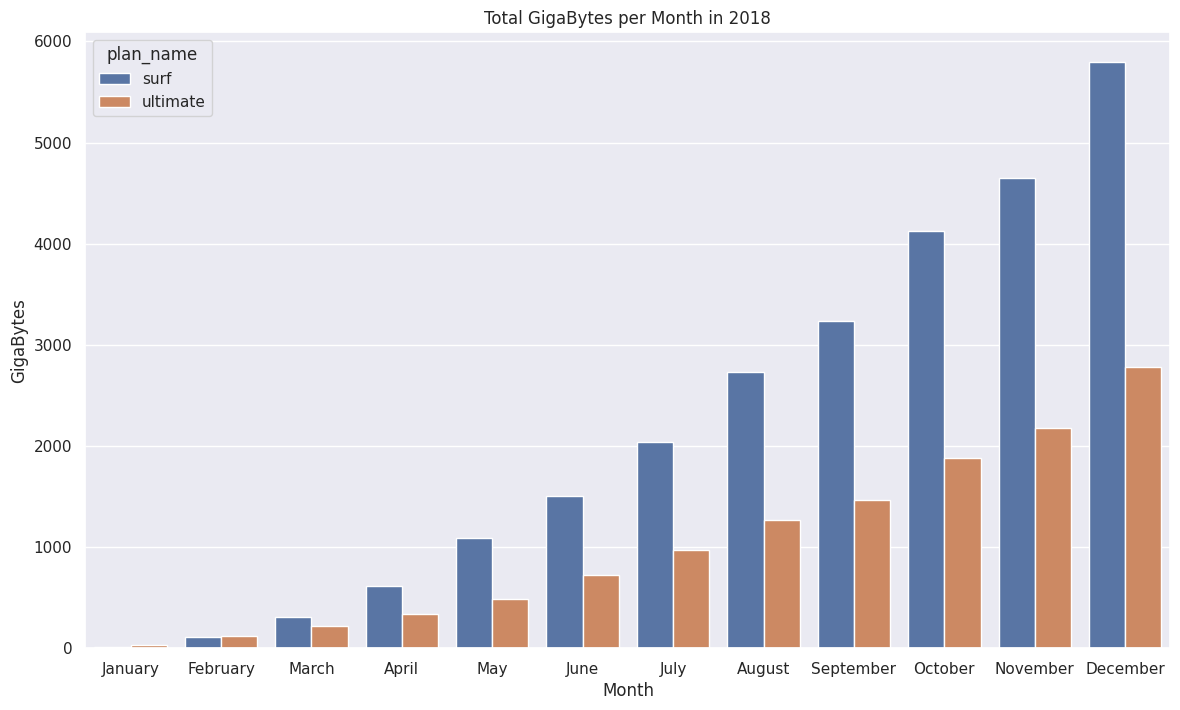

In [42]:
# Compare the number of GB used of each plan tend each month
net_trends = user_revenue.groupby(['plan_name', 'month'])['gb_used'].sum().reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

net_trends['month'] = pd.Categorical(net_trends['month'], categories=months_order, ordered=True)
net_trends = net_trends.sort_values('month')


sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(data = net_trends, x='month', y='gb_used', hue='plan_name', ax =ax)

plt.title("Total GigaBytes per Month in 2018")
plt.xlabel('Month')
plt.ylabel('GigaBytes')
plt.show()

In [43]:
# Calculate the mean and the variance of the monthly GB used

net_mean_var = monthly_usage.groupby('month').agg({'gb_used': ['mean', 'var']}).reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

net_mean_var['month'] = pd.Categorical(net_mean_var['month'], categories=months_order, ordered=True)
net_mean_var = net_mean_var.sort_values('month')
net_mean_var['gb_used'] = np.ceil(net_mean_var['gb_used'])

net_mean_var

month gb_used      
                 mean   var
4     January     7.0  14.0
3    February    15.0  43.0
7       March    15.0  91.0
0       April    14.0  66.0
8         May    15.0  57.0
6        June    16.0  52.0
5        July    17.0  62.0
1      August    17.0  65.0
11  September    17.0  48.0
10    October    18.0  56.0
9    November    17.0  54.0
2    December    18.0  65.0

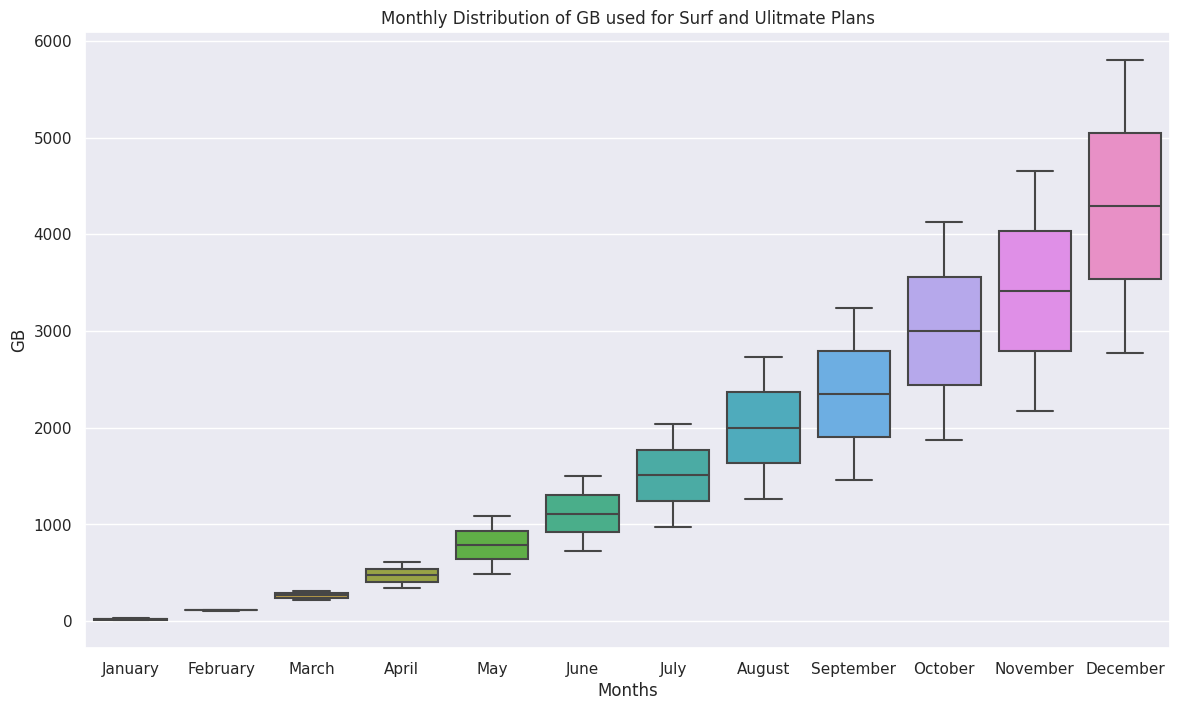

In [44]:
# Plot a boxplot to visualize the distribution of the monthly internet
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data =net_trends, y='gb_used', x='month', ax = ax )

plt.title("Monthly Distribution of GB used for Surf and Ulitmate Plans")
plt.xlabel('Months')
plt.ylabel('GB')

plt.show()

Internet Usage Analysis Summary

Our review of internet data usage per plan across distinct months revealed a compelling pattern. While usage remained relatively steady during the first half of the year, a **significant increase began in July**, continuing through **December**, where it reached its **highest levels**. This pattern suggests **heightened digital engagement during the second half of the year**, possibly influenced by seasonal factors like remote work, online shopping, and holiday activities.

In contrast, **January recorded the lowest internet usage**, potentially signaling **reduced online activity post-holidays**. This dip may reflect users taking a break from digital consumption or adjusting to new routines—an insight that could shape **future engagement strategies** during slower periods.

Notably, users on the **Surf plan** demonstrated **consistently higher data usage** month-over-month. This brings up several key considerations:
- Are Surf users more digitally active (e.g., streaming, browsing, downloading)?
- Has there been an increase in the number of Surf subscribers during high-usage months?
- Is there a usage behavior trend unique to Surf customers?

Even though **Ultimate plan users** have access to greater data capacity, **Surf users are consistently consuming more internet data**. This suggests stronger behavioral engagement or potentially a better fit between the plan features and user needs.

To capitalize on these insights, we recommend:
- Analyzing the **relationship between data usage and revenue**
- Exploring whether higher data consumption correlates with **loyalty or upsell potential**
- Considering **plan adjustments or targeted offers** to further encourage high-value usage

This data offers actionable insight for improving **product alignment**, **customer satisfaction**, and **strategic planning**.


## Revenue

Let's turn our focus to Revenue or in our case the main event!

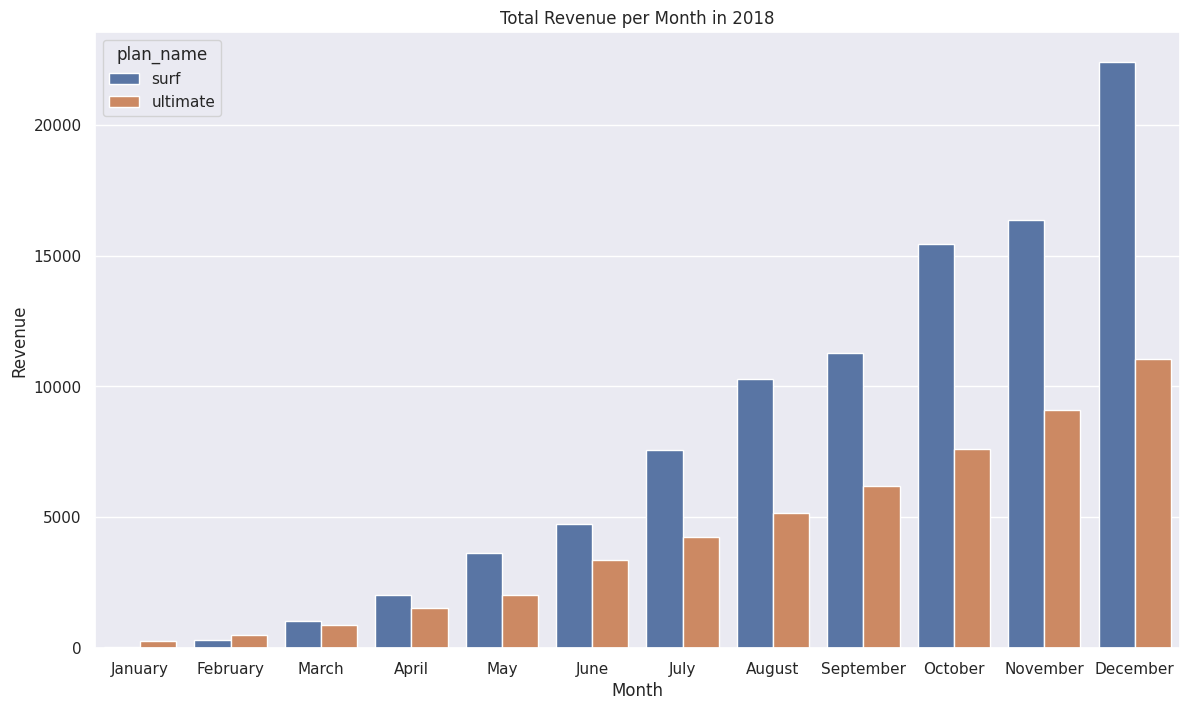

In [45]:
# Compare the revenue generated by each plan trend each month

rev_trends = revenue.groupby(['plan_name', 'month'])['revenue'].sum().reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

rev_trends['month'] = pd.Categorical(rev_trends['month'], categories=months_order, ordered=True)
rev_trends = rev_trends.sort_values('month')


sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(data = rev_trends, x='month', y='revenue', hue='plan_name', ax =ax)

plt.title("Total Revenue per Month in 2018")
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

In [46]:
# Calculate the mean and the variance of the monthly mbused(GB)

rev_mean_var = revenue.groupby('month').agg({'revenue': ['mean', 'var']}).reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

rev_mean_var['month'] = pd.Categorical(rev_mean_var['month'], categories=months_order, ordered=True)
rev_mean_var = rev_mean_var.sort_values('month')


rev_mean_var

month    revenue             
                    mean          var
4     January  53.333333   666.666667
3    February  49.973125   561.158223
7       March  55.790000  1216.825088
0       April  50.693286  1096.332814
8         May  54.269905  1538.794609
6        June  57.058873  1473.863172
5        July  65.932570  2027.309403
1      August  67.237913  2559.835070
11  September  62.642545  1627.457092
10    October  67.954631  2276.696856
9    November  62.438897  1790.464130
2    December  71.534808  3191.028395

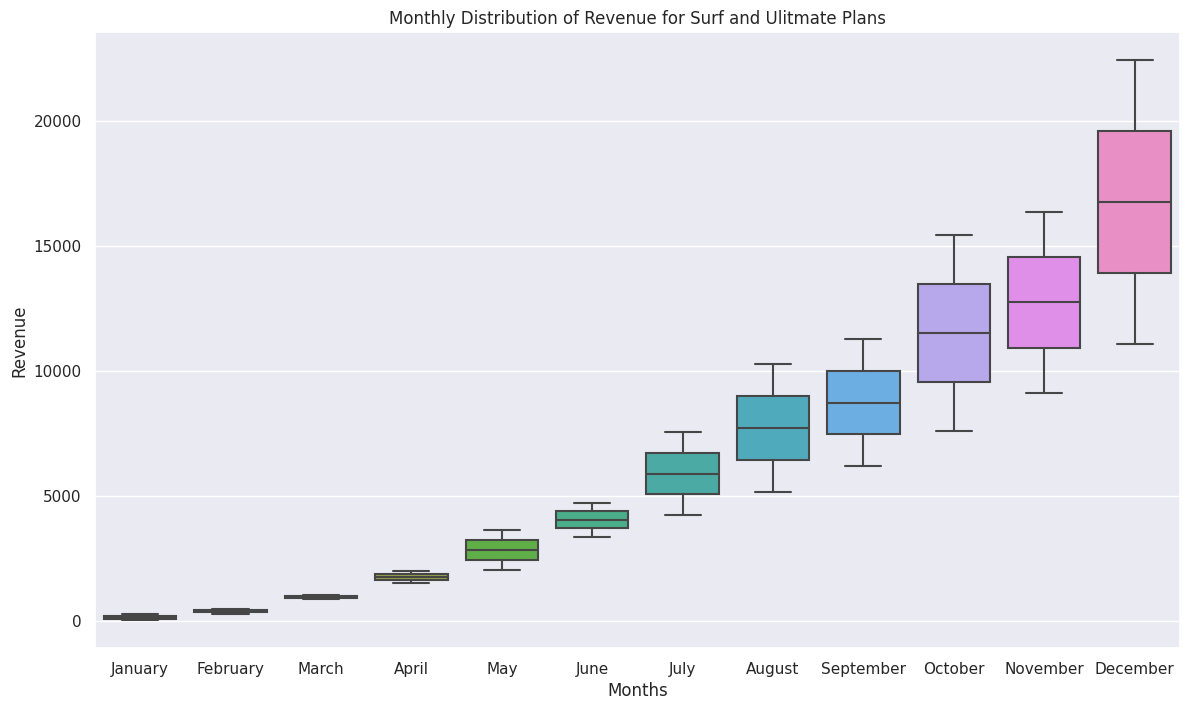

In [47]:
# Plot a boxplot to visualize the distribution of the monthly revenue
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data =rev_trends, y='revenue', x='month', ax = ax )

plt.title("Monthly Distribution of Revenue for Surf and Ulitmate Plans")
plt.xlabel('Months')
plt.ylabel('Revenue')

plt.show()

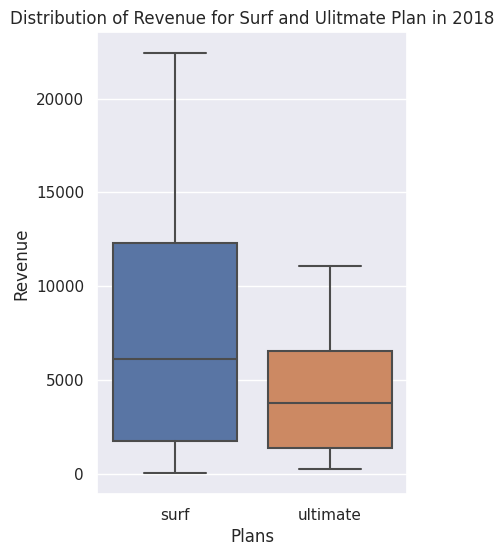

In [48]:
# Plot a boxplot to visualize the distribution of the monthly messages
fig, ax = plt.subplots(figsize=(4, 6))
sns.boxplot(data =rev_trends, y='revenue', x='plan_name', ax = ax )

plt.title("Distribution of Revenue for Surf and Ulitmate Plan in 2018")
plt.xlabel('Plans')
plt.ylabel('Revenue')

plt.show()

### Revenue Analysis Summary

Revenue trends closely mirror the usage patterns observed across calls, messages, and internet data. During the **first half of the year**, revenue remained relatively stable across all plans. However, starting in **July**, there was a **sharp and sustained increase**, with **December marking the highest revenue month**. This suggests that user activity—whether through higher engagement or increased plan adoption—directly contributed to elevated revenue during the latter half of the year.

**January emerged as the lowest revenue month**, likely a result of reduced usage across services following the holiday season. This seasonal dip provides a clear opportunity for **early-year marketing strategies** focused on reactivation, retention, or promoting bundled services to boost revenue during this slower period.

Once again, the **Surf plan** played a key role, contributing significantly to the revenue spike. This raises several important questions:
- Is revenue growth being driven by **increased user activity** or **subscriber growth** within the Surf plan?
- Are **usage-based charges or overages** contributing to higher revenue?
- Does Surf’s pricing model create more opportunities for **value capture**?

Interestingly, while **Ultimate plan users have more service capacity**, the **Surf plan consistently delivers higher revenue performance**. This highlights potential differences in **engagement levels**, **plan value alignment**, or **customer acquisition trends**.

Key areas for further exploration include:
- Understanding the **drivers of revenue growth per plan**
- Identifying upsell or cross-sell opportunities tied to high-usage behavior
- Evaluating if pricing structures are optimized to **maximize revenue without sacrificing user satisfaction**

These insights can help guide **pricing strategies**, **customer segmentation**, and **future revenue forecasting**.


 ### Overage & Member discovery

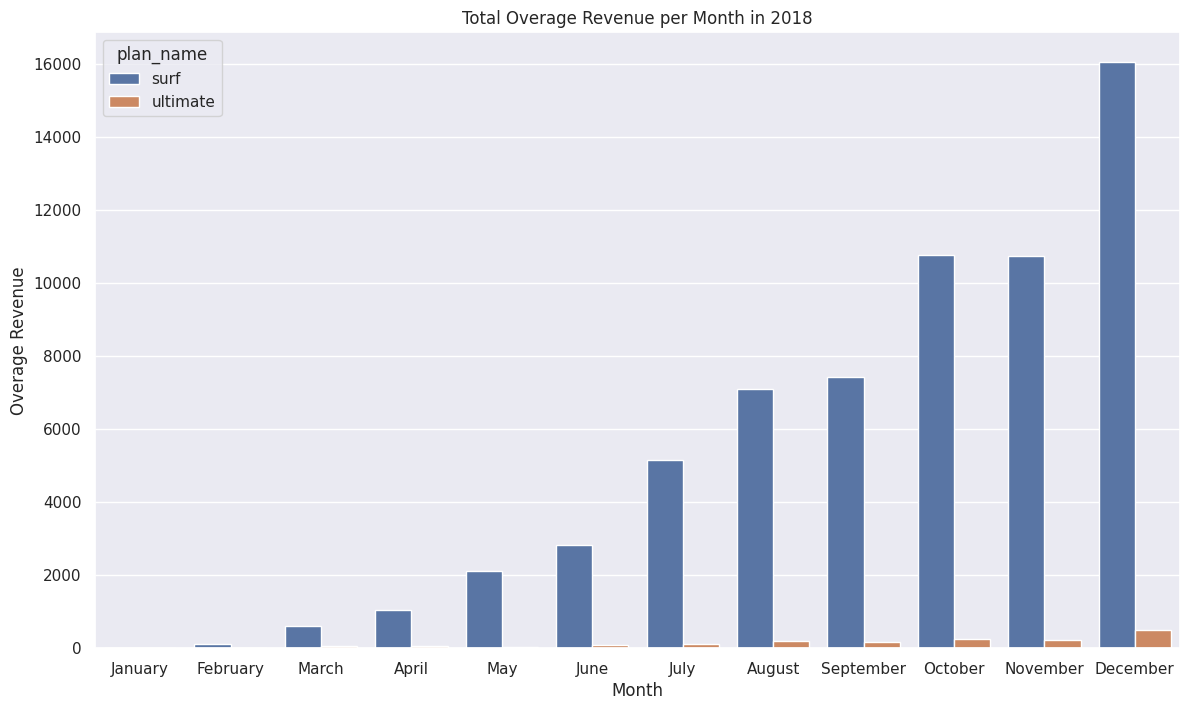

In [49]:
ov_rev_trends = user_revenue.groupby(['plan_name', 'month'])['overage_rev'].sum().reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

ov_rev_trends['month'] = pd.Categorical(ov_rev_trends['month'], categories=months_order, ordered=True)
ov_rev_trends = ov_rev_trends.sort_values('month')


sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(data = ov_rev_trends, x='month', y='overage_rev', hue='plan_name', ax =ax)

plt.title("Total Overage Revenue per Month in 2018")
plt.xlabel('Month')
plt.ylabel('Overage Revenue')
plt.show()

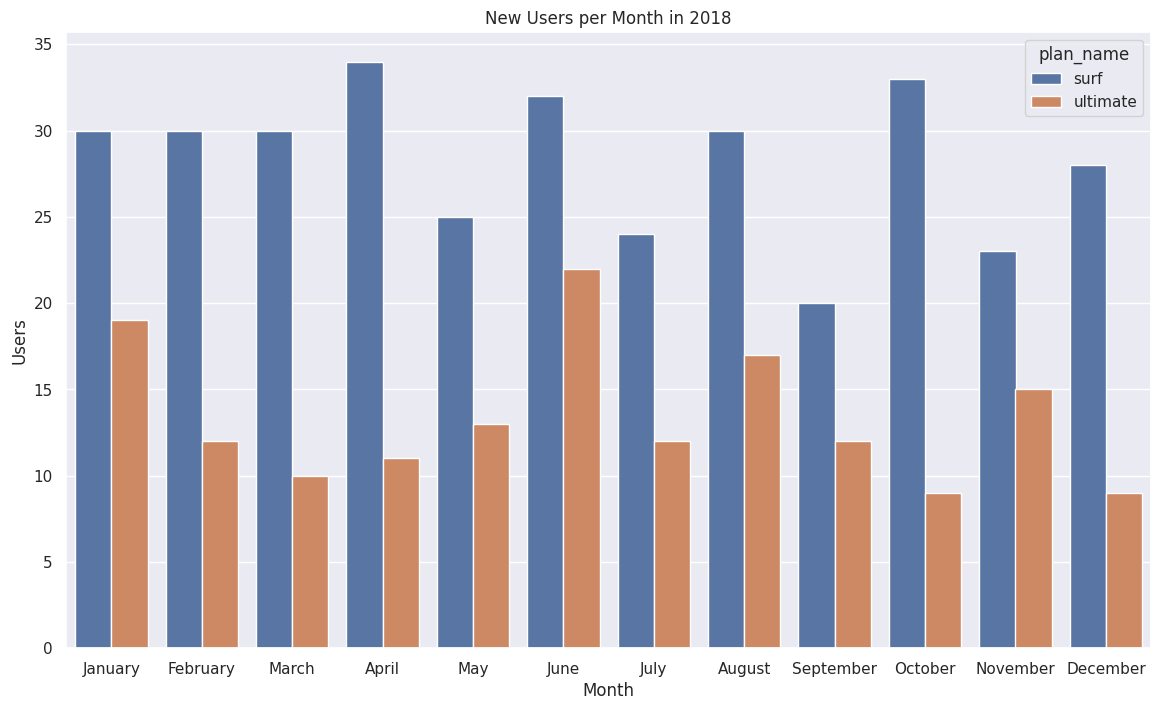

In [50]:
join_trends = users.groupby(['plan_name', 'month_joined'])['user_id'].count().reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

join_trends['month_joined'] = pd.Categorical(join_trends['month_joined'], categories=months_order, ordered=True)
join_trends = join_trends.sort_values('month_joined')


sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(data = join_trends, x='month_joined', y='user_id', hue='plan_name', ax =ax)

plt.title("New Users per Month in 2018")
plt.xlabel('Month')
plt.ylabel('Users')
plt.show()

In [51]:
churn = users[['user_id','churn_date']]
churning_data = user_revenue.merge(churn, on = 'user_id')
churning_only = churning_data.dropna()



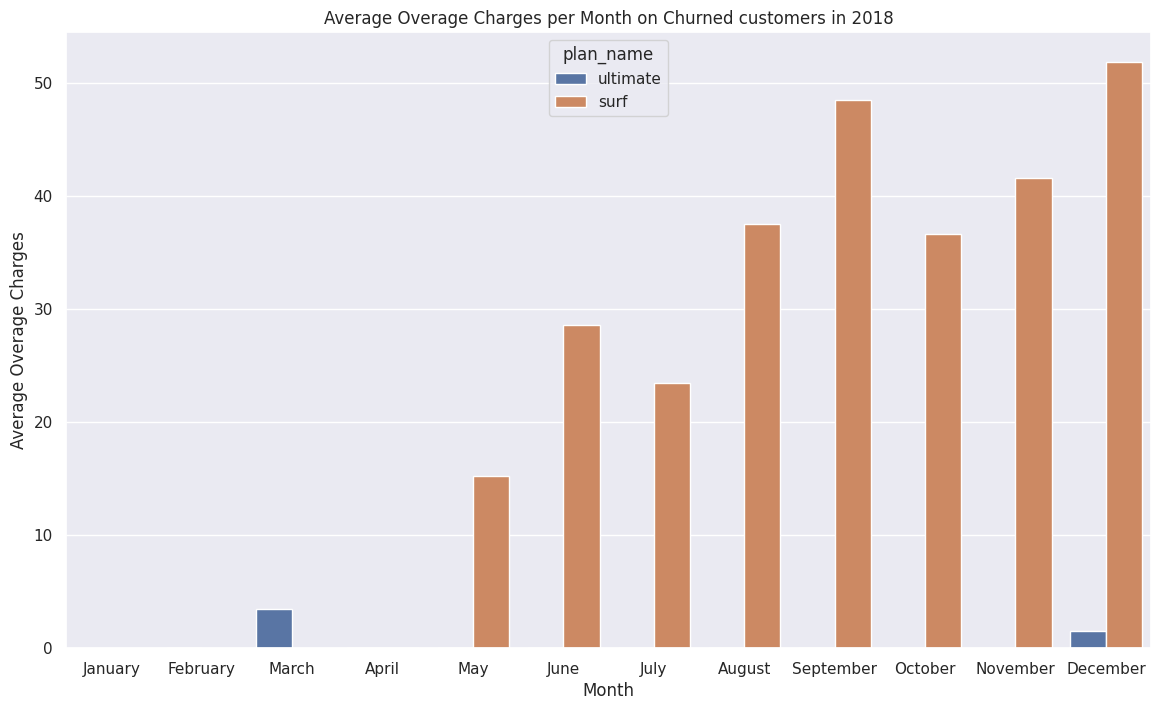

In [52]:
churn_trends = churning_only.groupby([ 'month', 'plan_name']).agg({'overage_rev': 'mean'}).reset_index()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

churn_trends['month'] = pd.Categorical(churn_trends['month'], categories=months_order, ordered=True)
churn_trends = churn_trends.sort_values('month')


sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(data = churn_trends, x='month', y='overage_rev', hue='plan_name', ax =ax)

plt.title("Average Overage Charges per Month on Churned customers in 2018")
plt.xlabel('Month')
plt.ylabel('Average Overage Charges')
plt.show()



### Additional Observations

While investigating potential drivers behind the increased usage and revenue trends, we examined **monthly new user sign-up volumes**. Surprisingly, the data revealed **no significant upward trend in new user acquisition** throughout the year. 

This indicates that the observed surge in activity and revenue is **not attributable to subscriber growth**, but rather to **behavioral changes among the existing user base**. These changes—such as increased service consumption and overage charges—appear to be the primary contributors to revenue acceleration in the latter half of the year.

A deeper dive into the **Surf plan** revealed a critical insight:  
> **Overage charges accounted for a substantial portion of the revenue growth**, closely following the same upward trend seen in usage and total revenue from July through December.

> **Average monthly overage charges for churned customers revealed** a low amount of churned customers but surf members were on churning more than ultimate so far.

This indicates that Surf users are:
- **Consistently exceeding their plan limits**
- Potentially **underestimating their needs** or unaware of plan thresholds
- Driving **incremental revenue** through unintentional overage costs

These findings raise several strategic considerations:
- Should overage charges be revisited to ensure **user satisfaction** and avoid churn?
- Is there an opportunity to **upsell Surf users** to higher-tier plans like Ultimate?
- Would clearer **usage notifications or usage-based recommendations** improve transparency and trust?

Understanding and addressing this overage-driven revenue stream is essential to **balance monetization with customer experience** and could unlock further opportunities for **personalized plan optimization**.


## Test statistical hypotheses

**Null Hypothesis (H₀):**  
There is **no difference** in the average revenue generated by users of the Ultimate and Surf calling plans.  
(μ_Ultimate = μ_Surf)

**Alternative Hypothesis (H₁):**  
There **is a difference** in the average revenue generated by users of the Ultimate and Surf calling plans.  
(μ_Ultimate ≠ μ_Surf)

In [53]:
# Test the hypotheses
rev_mean_var = user_revenue.groupby(['user_id','plan_name']).agg({'revenue': 'mean'}).reset_index()



rev_mean_surf = rev_mean_var[rev_mean_var['plan_name']=='surf']['revenue']
rev_mean_ultimate = rev_mean_var[rev_mean_var['plan_name']=='ultimate']['revenue']

#Hypothesis on the Equality of Two Population Means
#We don't expect the variances to be the same, so set the equal_var parameter to False.

alpha = 0.05


results = st.ttest_ind(rev_mean_ultimate, rev_mean_surf,  equal_var =False)

print('p-value:', results.pvalue )
if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
    
    
    



p-value: 8.716443618548544e-08
We reject the null hypothesis


**Null Hypothesis (H₀):**  
There is **no difference** in the average revenue generated by users in the **NY-NJ region** and users in **other regions**.  
(μ_NY_NJ = μ_Other)

**Alternative Hypothesis (H₁):**  
There **is a difference** in the average revenue generated by users in the **NY-NJ region** and users in **other regions**.  
(μ_NY_NJ ≠ μ_Other)


In [54]:
# Test the hypotheses
reg_mean_var = user_revenue.groupby(['user_id','region','plan_name']).agg({'revenue': 'mean'}).reset_index()

reg_mean_ny_nj = reg_mean_var[reg_mean_var['region']=='NY-NJ']['revenue']
reg_mean_other = reg_mean_var[reg_mean_var['region']!='NY-NJ']['revenue']
#Hypothesis on the Equality of Two Population Means
#We don't expect the variances to be the same, so set the equal_var parameter to False.

alpha = 0.05


results = st.ttest_ind(reg_mean_ny_nj, reg_mean_other, equal_var =False)

print('p-value:', results.pvalue )
if results.pvalue < alpha:# your code: compare the p-value you get with the significance level:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")



p-value: 0.4199603650142283
We can't reject the null hypothesis


### ✅ Hypothesis 3: Churned Users Generate Less Revenue Than Active Users

- **Objective:** Explore how customer churn affects revenue by comparing average monthly revenue between churned and active users.
  
#### 🧪 Hypothesis Statement:
- **Null Hypothesis (H₀):** There is **no difference** in average monthly revenue between churned and active users.
- **Alternative Hypothesis (H₁):** **Churned users generate less** average monthly revenue than active users.

#### 🧮 Test Method:
- Perform an **independent two-sample t-test** comparing average monthly revenue of users with a `churn_date` (churned) vs. those without it (active).

#### 📈 Expected Insight:
If the null hypothesis is rejected, it will confirm that **churn significantly impacts revenue**, validating the need for **retention-focused strategies** (e.g., loyalty programs, early warning churn indicators).

> 🔍 This analysis can help prioritize user retention as a **key revenue protection lever**.


In [55]:
# Test the hypotheses
rev_mean_churn = churning_data.groupby(['user_id','churn_date']).agg({'revenue': 'mean'}).reset_index()
rev_mean_active = churning_data[churning_data['churn_date'].isna()]
rev_mean_active = rev_mean_active.groupby(['user_id']).agg({'revenue': 'mean'}).reset_index()
#Hypothesis on the Equality of Two Population Means
#We don't expect the variances to be the same, so set the equal_var parameter to False.

rev_mean_active = rev_mean_active['revenue']
rev_mean_churn = rev_mean_churn['revenue']
alpha = 0.05


results = st.ttest_ind(rev_mean_churn, rev_mean_active, equal_var =False)

print('p-value:', results.pvalue )
if results.pvalue < alpha:# your code: compare the p-value you get with the significance level:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")




p-value: 0.7990285664954085
We can't reject the null hypothesis


# 📈 Conclusion

After completing a comprehensive revenue attribution analysis for Megaline’s prepaid plans — **Surf** and **Ultimate** — several critical insights have emerged to guide strategic decision-making.

---

## 🔍 Key Findings

- The **Surf plan** consistently showed **higher user engagement** across calls, messages, and internet data compared to the Ultimate plan.
- Despite Ultimate's higher base monthly charge and larger service bundles, the **Surf plan generated higher overall revenue** during the study period.
- This **higher revenue** was primarily driven by **overage charges**, as Surf users frequently exceeded their plan limits for voice, messaging, and data usage.
- Revenue trends showed clear seasonality, with significant increases from **July through December**, peaking during the holiday season.
- Importantly, this surge was **not driven by an increase in new users**, but rather by **greater engagement among existing users**.

---

## 💰 More Profitable Plan

> 🎯 **The Surf plan is the more profitable plan** based on 2018 usage and revenue data.

Strategic recommendation: **Reallocate marketing resources** to promote the Surf plan more aggressively, while also considering opportunities to **upsell Surf users** to prevent churn due to excessive overage charges.

---

## 📊 Hypothesis Testing Results

### ✅ Hypothesis 1: Revenue Difference Between Surf and Ultimate Plans

- **Null Hypothesis (H₀):** There is **no difference** in the average revenue generated by users of the Ultimate and Surf plans.  
- **Alternative Hypothesis (H₁):** There **is a difference** in the average revenue generated by users of the Ultimate and Surf plans.

**p-value: 8.716443618548544e-08**

> 📢 **Result:** We **reject the null hypothesis** — There is a statistically significant difference in revenue between the two plans, with **Surf users generating higher average revenue**.

---
### ✅ Hypothesis 2: Revenue Difference Between NY-NJ Region and Other Regions

- **Null Hypothesis (H₀):** There is **no difference** in average revenue between users in the NY-NJ region and users in other regions.  
- **Alternative Hypothesis (H₁):** There **is a difference** in average revenue between users in the NY-NJ region and users in other regions.

**p-value: 0.4199603650142283**

> 📢 **Result:** We **cannot reject the null hypothesis** — There is **no statistically significant difference** in average revenue between the NY-NJ region and other areas. Therefore, **region-specific revenue strategies may not be necessary**.


---

### ✅ Hypothesis 3: Churned Users Generate Less Revenue Than Active Users

- **Objective:** Explore how customer churn affects revenue by comparing average monthly revenue between churned and active users.
  
#### 🧪 Hypothesis Statement:
- **Null Hypothesis (H₀):** There is **no difference** in average monthly revenue between churned and active users.
- **Alternative Hypothesis (H₁):** **Churned users generate less** average monthly revenue than active users.

**p-value: 0.7990285664954085**

> 📢 **Result:** We **cannot reject the null hypothesis** — There is no statistically significant difference in average revenue between churned and active users. This suggests that churned users were not necessarily lower-revenue contributors prior to leaving.

---

## 🎯 Strategic Recommendations

- **Focus marketing efforts** on acquiring and retaining **Surf plan customers**, leveraging their high engagement and revenue potential.
- **Monitor overage trends** and consider **upselling high-usage Surf users** to prevent dissatisfaction from unexpected charges.
- **Refine churn prediction models** to identify high-value users at risk of churn, since revenue alone is not a reliable indicator.

By using these insights, Megaline can **optimize resource allocation**, **boost customer lifetime value**, and **strengthen competitive positioning** in the prepaid mobile market.

---
